In [1]:
import torch
from diffuser.datasets.sequence import BBwdSequenceDataset, BBwDirStatSequenceDataset

/home/xchen/anaconda3/envs/diffuser/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
pybullet build time: May 20 2022 19:44:17


In [2]:
import diffuser.utils as utils

from diffuser.datasets.sequence import BBwdSequenceDataset, BBwDirStatSequenceDataset


#-----------------------------------------------------------------------------#
#----------------------------------- setup -----------------------------------#
#-----------------------------------------------------------------------------#

class Parser(utils.Parser):
    dataset: str = 'basketball_single_game_wDirStat'
    config: str = 'config.locomotion'

args = Parser().parse_args('diffusion')

args.horizon = 1024
args.batch_size = 1
args.learning_rate = 2e-5
args.dataset == "basketball_single_game_wDirStat"
#-----------------------------------------------------------------------------#
#---------------------------------- dataset ----------------------------------#
#-----------------------------------------------------------------------------#

dataset_config = utils.Config(
    args.loader,
    savepath=(args.savepath, 'dataset_config.pkl'),
    env=args.dataset,
    horizon=args.horizon,
    normalizer=args.normalizer,
    preprocess_fns=args.preprocess_fns,
    use_padding=args.use_padding,
    max_path_length=args.max_path_length,
)

render_config = utils.Config(
    args.renderer,
    savepath=(args.savepath, 'render_config.pkl'),
    env=args.dataset,
)



dataset = BBwDirStatSequenceDataset("/home/xchen/MURI/diffuser/0021500549_dir_stats_reshape.npy")


# renderer = render_config()
renderer = None

observation_dim = dataset.observation_dim
action_dim = dataset.action_dim



#-----------------------------------------------------------------------------#
#------------------------------ model & trainer ------------------------------#
#-----------------------------------------------------------------------------#

model_config = utils.Config(
    args.model,
    savepath=(args.savepath, 'model_config.pkl'),
    horizon=args.horizon,
    transition_dim=observation_dim + action_dim,
    cond_dim=observation_dim,
    dim_mults=args.dim_mults,
    attention=args.attention,
    device=args.device,
)

diffusion_config = utils.Config(
    args.diffusion,
    savepath=(args.savepath, 'diffusion_config.pkl'),
    horizon=args.horizon,
    observation_dim=observation_dim,
    action_dim=action_dim,
    n_timesteps=args.n_diffusion_steps,
    loss_type=args.loss_type,
    clip_denoised=args.clip_denoised,
    predict_epsilon=args.predict_epsilon,
    ## loss weighting
    action_weight=args.action_weight,
    loss_weights=args.loss_weights,
    loss_discount=args.loss_discount,
    device=args.device,
)

trainer_config = utils.Config(
    utils.Trainer,
    savepath=(args.savepath, 'trainer_config.pkl'),
    train_batch_size=args.batch_size,
    train_lr=args.learning_rate,
    gradient_accumulate_every=args.gradient_accumulate_every,
    ema_decay=args.ema_decay,
    sample_freq=args.sample_freq,
    save_freq=args.save_freq,
    label_freq=int(args.n_train_steps // args.n_saves),
    save_parallel=args.save_parallel,
    results_folder=args.savepath,
    bucket=args.bucket,
    n_reference=args.n_reference,
)

#-----------------------------------------------------------------------------#
#-------------------------------- instantiate --------------------------------#
#-----------------------------------------------------------------------------#

model = model_config()

diffusion = diffusion_config(model)

trainer = trainer_config(diffusion, dataset, renderer)



[ utils/setup ] Reading config: config.locomotion:basketball_single_game_wDirStat
[ utils/setup ] Using overrides | config: config.locomotion | dataset: basketball_single_game_wDirStat
[ utils/setup ] Setting exp_name to: diffusion/defaults_H1024_T20
[ utils/setup ] Saved args to logs/basketball_single_game_wDirStat/diffusion/defaults_H1024_T20/args.json
[ utils/config ] Imported diffuser.datasets:SequenceDataset

[utils/config ] Config: <class 'diffuser.datasets.sequence.SequenceDataset'>
    env: basketball_single_game_wDirStat
    horizon: 1024
    max_path_length: 1000
    normalizer: GaussianNormalizer
    preprocess_fns: []
    use_padding: True

[ utils/config ] Saved config to: logs/basketball_single_game_wDirStat/diffusion/defaults_H1024_T20/dataset_config.pkl

[ utils/config ] Imported diffuser.utils:MuJoCoRenderer

[utils/config ] Config: <class 'diffuser.utils.rendering.MuJoCoRenderer'>
    env: basketball_single_game_wDirStat

[ utils/config ] Saved config to: logs/basketb

In [27]:
trainer.load(8000)

In [28]:
trainer.render_samples()


                                                                                                    
1 / 20 [###                                                         ]   5% | 34.6 Hz
t : 19 | vmax : 0.0 | vmin : 0.0
                                                                                                    
                                                                                                    
2 / 20 [######                                                      ]  10% | 40.0 Hz
t : 18 | vmax : 0.0 | vmin : 0.0
                                                                                                    
                                                                                                    
3 / 20 [#########                                                   ]  15% | 41.3 Hz
t : 17 | vmax : 0.0 | vmin : 0.0
                                                                                                    
                                       

                                                                                                    
                                                                                                    
12 / 20 [####################################                        ]  60% | 41.9 Hz
t : 8 | vmax : 0.0 | vmin : 0.0
                                                                                                    
                                                                                                    
13 / 20 [#######################################                     ]  65% | 42.2 Hz
t : 7 | vmax : 0.0 | vmin : 0.0
                                                                                                    
                                                                                                    
14 / 20 [##########################################                  ]  70% | 41.9 Hz
t : 6 | vmax : 0.0 | vmin : 0.0
                                        

In [29]:
import torch

with open("/home/xchen/MURI/diffuser/logs/basketball_single_game_wDirStat/diffusion/defaults_H1024_T20/sample-11000-0.npy", 'rb') as fin:
    observations = torch.load(fin)

In [30]:
observations.shape

(2, 1025, 242)

In [31]:
observations[0][0][:32]

array([ 6.36740017e+00,  2.48461208e+01,  1.07704897e+01,  9.69467163e-02,
       -7.96089172e-02, -8.00304413e-02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  3.46404343e+01,  2.88041821e+01,
        0.00000000e+00,  2.36770630e-01,  1.18040085e-01,  0.00000000e+00,
        2.62000000e+02,  7.51000000e+02,  3.49000007e-01,  9.00000000e+01],
      dtype=float32)

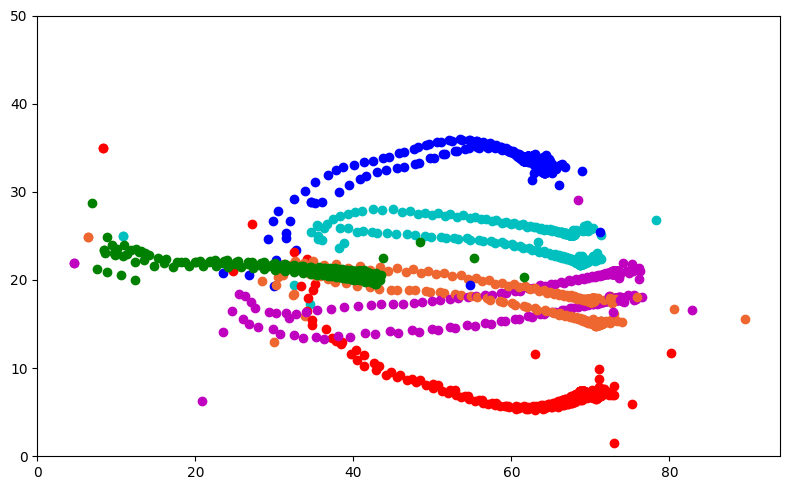

In [32]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import scatter

plt.figure(figsize=(8,5))
plt.xlim(0, 94)
plt.ylim(0, 50)
for i in range(1025):
    plt.scatter(observations[0][i][0], observations[0][i][1], color='#ee6730')
    plt.scatter(observations[0][i][22], observations[0][i][23], color='b')
    plt.scatter(observations[0][i][44], observations[0][i][45], color='g')
    plt.scatter(observations[0][i][66], observations[0][i][67], color='r')
    plt.scatter(observations[0][i][88], observations[0][i][89], color='c')
    plt.scatter(observations[0][i][110], observations[0][i][111], color='m')

plt.tight_layout()
#     plt.show()
plt.savefig('LAL_11000_0.png')
# print(counterfactual_KD_ending_positions)

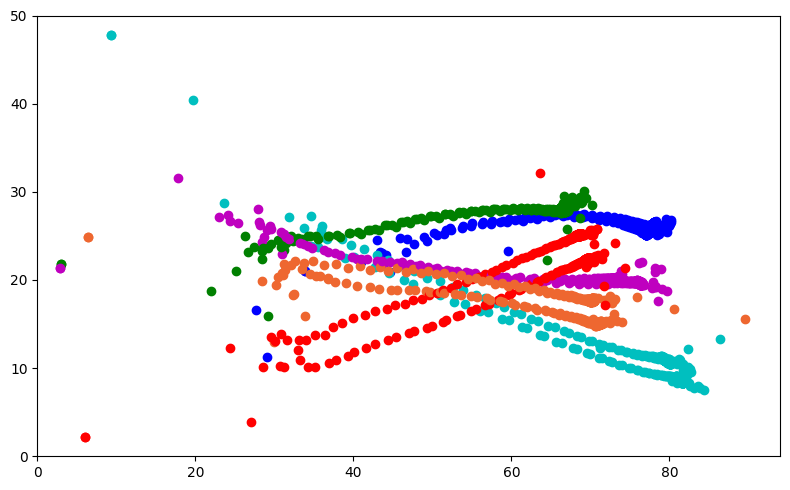

In [33]:
plt.figure(figsize=(8,5))
plt.xlim(0, 94)
plt.ylim(0, 50)
for i in range(1025):
    plt.scatter(observations[0][i][0], observations[0][i][1], color='#ee6730')
    plt.scatter(observations[0][i][132], observations[0][i][133], color='b')
    plt.scatter(observations[0][i][154], observations[0][i][155], color='g')
    plt.scatter(observations[0][i][176], observations[0][i][177], color='r')
    plt.scatter(observations[0][i][198], observations[0][i][199], color='c')
    plt.scatter(observations[0][i][220], observations[0][i][221], color='m')

plt.tight_layout()
#     plt.show()
plt.savefig('OKC_11000_0.png')
# print(counterfactual_KD_ending_positions)

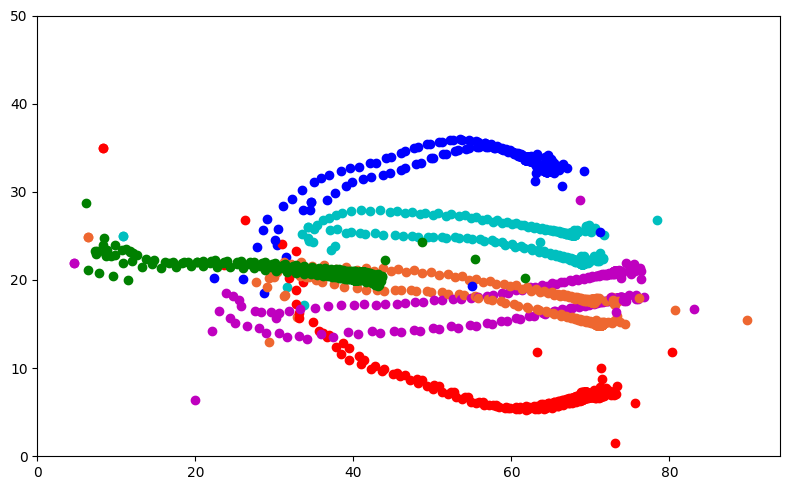

In [34]:
# import matplotlib.pyplot as plt
# from matplotlib.pyplot import scatter

plt.figure(figsize=(8,5))
plt.xlim(0, 94)
plt.ylim(0, 50)
for i in range(1025):
    plt.scatter(observations[1][i][0], observations[1][i][1], color='#ee6730')
    plt.scatter(observations[1][i][22], observations[1][i][23], color='b')
    plt.scatter(observations[1][i][44], observations[1][i][45], color='g')
    plt.scatter(observations[1][i][66], observations[1][i][67], color='r')
    plt.scatter(observations[1][i][88], observations[1][i][89], color='c')
    plt.scatter(observations[1][i][110], observations[1][i][111], color='m')

plt.tight_layout()
#     plt.show()
plt.savefig('LAL_11000_1.png')
# print(counterfactual_KD_ending_positions)

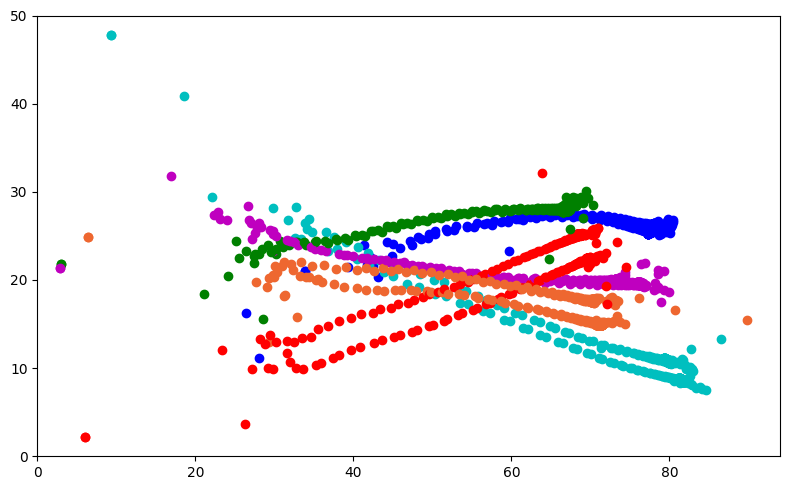

In [35]:
plt.figure(figsize=(8,5))
plt.xlim(0, 94)
plt.ylim(0, 50)
for i in range(1025):
    plt.scatter(observations[1][i][0], observations[1][i][1], color='#ee6730')
    plt.scatter(observations[1][i][132], observations[1][i][133], color='b')
    plt.scatter(observations[1][i][154], observations[1][i][155], color='g')
    plt.scatter(observations[1][i][176], observations[1][i][177], color='r')
    plt.scatter(observations[1][i][198], observations[1][i][199], color='c')
    plt.scatter(observations[1][i][220], observations[1][i][221], color='m')

plt.tight_layout()
#     plt.show()
plt.savefig('OKC_11000_1.png')
# print(counterfactual_KD_ending_positions)

In [12]:
with open("/home/xchen/MURI/diffuser/logs/basketball_single_game_wd/diffusion/defaults_H1024_T20/sample-180000-1.npy", 'rb') as fin:
    observations_1 = torch.load(fin)

In [14]:
observations_1.shape

(2, 1025, 66)

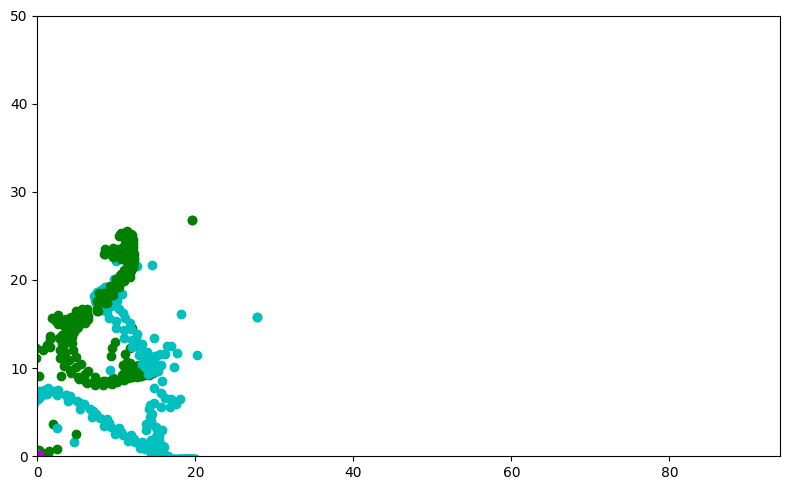

In [15]:
# import matplotlib.pyplot as plt
# from matplotlib.pyplot import scatter

plt.figure(figsize=(8,5))
plt.xlim(0, 94)
plt.ylim(0, 50)
for i in range(1025):
    plt.scatter(observations_1[0][i][3], observations_1[0][i][4], color='b')
    plt.scatter(observations_1[0][i][6], observations_1[0][i][7], color='g')
    plt.scatter(observations_1[0][i][9], observations_1[0][i][10], color='r')
    plt.scatter(observations_1[0][i][12], observations_1[0][i][13], color='c')
    plt.scatter(observations_1[0][i][15], observations_1[0][i][16], color='m')

plt.tight_layout()
#     plt.show()
plt.savefig('LAL_1.png')
# print(counterfactual_KD_ending_positions)

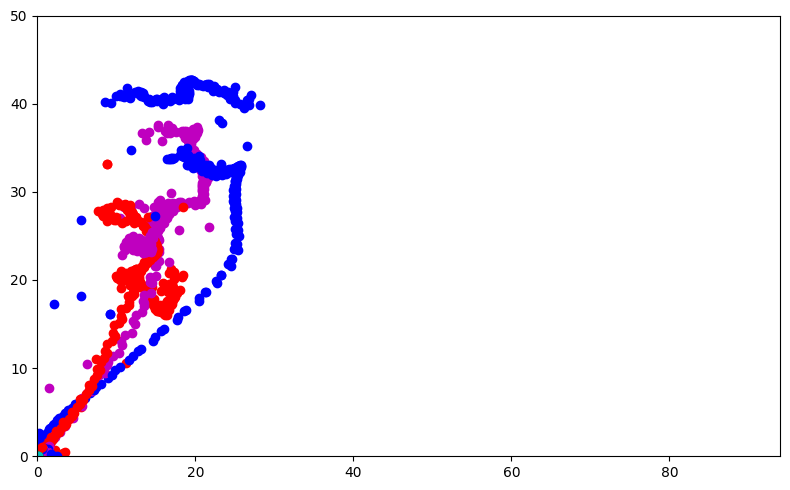

In [16]:
plt.figure(figsize=(8,5))
plt.xlim(0, 94)
plt.ylim(0, 50)
for i in range(1025):
    plt.scatter(observations_1[0][i][18], observations_1[0][i][19], color='b')
    plt.scatter(observations_1[0][i][21], observations_1[0][i][22], color='g')
    plt.scatter(observations_1[0][i][24], observations_1[0][i][25], color='r')
    plt.scatter(observations_1[0][i][27], observations_1[0][i][28], color='c')
    plt.scatter(observations_1[0][i][30], observations_1[0][i][31], color='m')

plt.tight_layout()
#     plt.show()
plt.savefig('OKC_1.png')
# print(counterfactual_KD_ending_positions)

In [41]:
import torch

with open("/home/xchen/MURI/diffuser/logs/basketball_single_game_wd/diffusion/defaults_H1024_T20/sample-380000-0.npy", 'rb') as fin:
    observations_380000 = torch.load(fin)

In [42]:
observations_380000.shape

(2, 1025, 66)

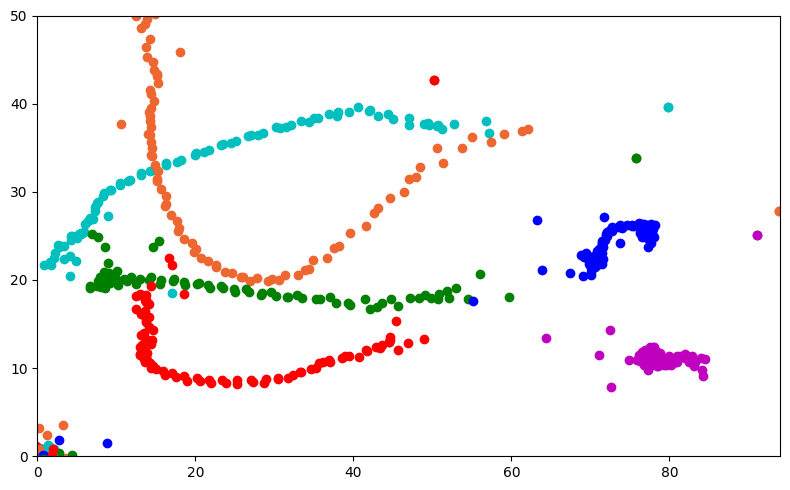

In [43]:
# import matplotlib.pyplot as plt
# from matplotlib.pyplot import scatter

plt.figure(figsize=(8,5))
plt.xlim(0, 94)
plt.ylim(0, 50)
for i in range(1025):
    plt.scatter(observations_380000[0][i][0], observations_380000[0][i][1], color='#ee6730')
    plt.scatter(observations_380000[0][i][6], observations_380000[0][i][7], color='b')
    plt.scatter(observations_380000[0][i][12], observations_380000[0][i][13], color='g')
    plt.scatter(observations_380000[0][i][18], observations_380000[0][i][19], color='r')
    plt.scatter(observations_380000[0][i][24], observations_380000[0][i][25], color='c')
    plt.scatter(observations_380000[0][i][30], observations_380000[0][i][31], color='m')

plt.tight_layout()
#     plt.show()
plt.savefig('LAL_380000.png')
# print(counterfactual_KD_ending_positions)

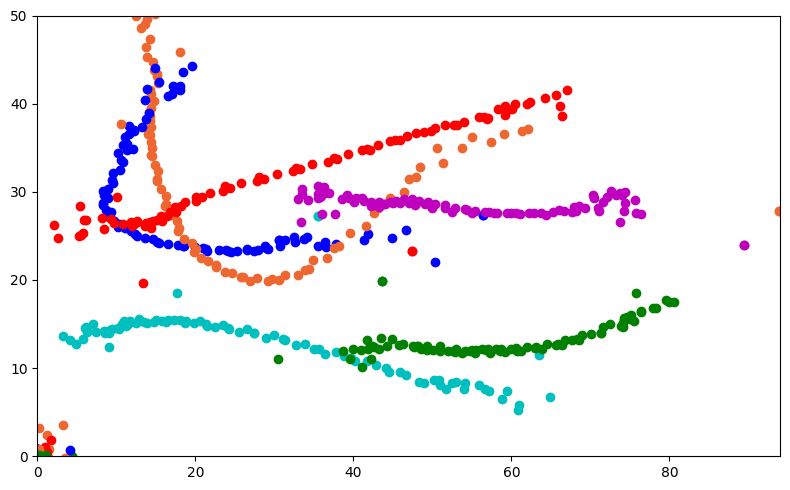

In [44]:
plt.figure(figsize=(8,5))
plt.xlim(0, 94)
plt.ylim(0, 50)
for i in range(1025):
    plt.scatter(observations_380000[0][i][0], observations_380000[0][i][1], color='#ee6730')
    plt.scatter(observations_380000[0][i][36], observations_380000[0][i][37], color='b')
    plt.scatter(observations_380000[0][i][42], observations_380000[0][i][43], color='g')
    plt.scatter(observations_380000[0][i][48], observations_380000[0][i][49], color='r')
    plt.scatter(observations_380000[0][i][54], observations_380000[0][i][55], color='c')
    plt.scatter(observations_380000[0][i][60], observations_380000[0][i][61], color='m')

plt.tight_layout()
#     plt.show()
plt.savefig('OKC_380000.png')
# print(counterfactual_KD_ending_positions)

In [20]:
import torch

with open("/home/xchen/MURI/diffuser/logs/basketball_single_game_wd/diffusion/defaults_H1024_T20/sample-580000-0.npy", 'rb') as fin:
    observations_580000 = torch.load(fin)

In [21]:
observations_580000.shape

(2, 1025, 66)

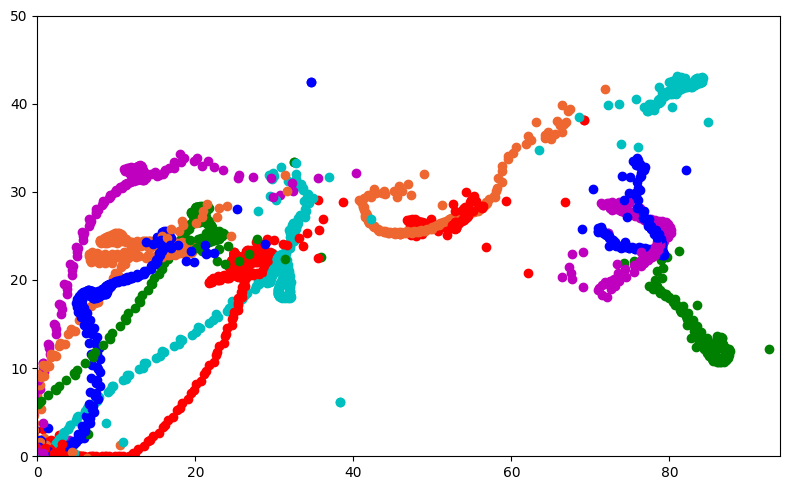

In [37]:
# import matplotlib.pyplot as plt
# from matplotlib.pyplot import scatter

plt.figure(figsize=(8,5))
plt.xlim(0, 94)
plt.ylim(0, 50)
for i in range(1025):
    plt.scatter(observations_580000[0][i][0], observations_580000[0][i][1], color='#ee6730')
    plt.scatter(observations_580000[0][i][6], observations_580000[0][i][7], color='b')
    plt.scatter(observations_580000[0][i][12], observations_580000[0][i][13], color='g')
    plt.scatter(observations_580000[0][i][18], observations_580000[0][i][19], color='r')
    plt.scatter(observations_580000[0][i][24], observations_580000[0][i][25], color='c')
    plt.scatter(observations_580000[0][i][30], observations_580000[0][i][31], color='m')

plt.tight_layout()
#     plt.show()
plt.savefig('LAL_580000.png')
# print(counterfactual_KD_ending_positions)

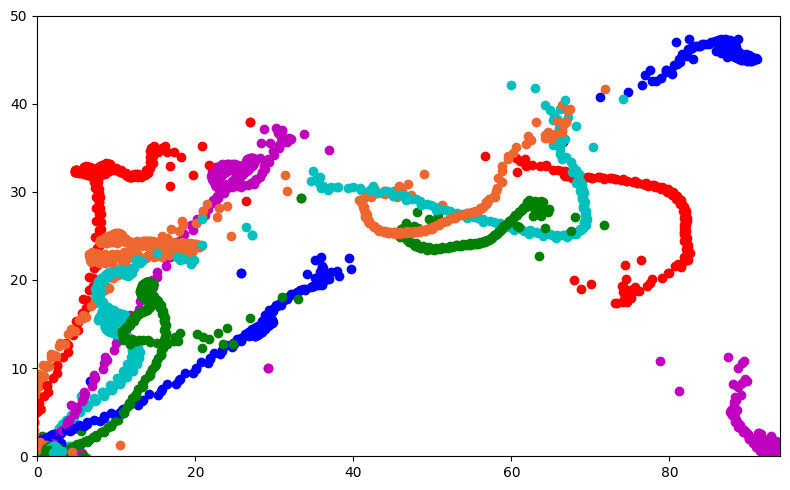

In [38]:
plt.figure(figsize=(8,5))
plt.xlim(0, 94)
plt.ylim(0, 50)
for i in range(1025):
    plt.scatter(observations_580000[0][i][0], observations_580000[0][i][1], color='#ee6730')
    plt.scatter(observations_580000[0][i][36], observations_580000[0][i][37], color='b')
    plt.scatter(observations_580000[0][i][42], observations_580000[0][i][43], color='g')
    plt.scatter(observations_580000[0][i][48], observations_580000[0][i][49], color='r')
    plt.scatter(observations_580000[0][i][54], observations_580000[0][i][55], color='c')
    plt.scatter(observations_580000[0][i][60], observations_580000[0][i][61], color='m')

plt.tight_layout()
#     plt.show()
plt.savefig('OKC_580000.png')
# print(counterfactual_KD_ending_positions)

In [27]:
observations[0][0]

array([ 6.45178223e+01, -1.09505939e+00,  5.03374004e+00,  1.81640625e-01,
        3.59310150e-01, -3.05230141e-01,  7.52672806e+01,  1.70375996e+01,
        0.00000000e+00, -5.71983337e-01, -3.03419113e-01,  0.00000000e+00,
        8.53519669e+01,  1.06989298e+01,  0.00000000e+00, -1.08795166e-02,
        1.77898407e-02,  0.00000000e+00,  7.77771835e+01,  2.25124092e+01,
        0.00000000e+00, -1.12586975e-01, -2.69590378e-01,  0.00000000e+00,
        8.02532730e+01,  3.84943085e+01,  0.00000000e+00,  4.44084167e-01,
        2.99449921e-01,  0.00000000e+00,  6.71857681e+01,  1.07219815e-01,
        0.00000000e+00, -3.99017334e-02,  5.46417236e-02,  0.00000000e+00,
        7.84087906e+01,  2.07443905e+01,  0.00000000e+00, -2.12707520e-01,
       -2.03559875e-01,  0.00000000e+00,  7.62873077e+01,  3.01414108e+01,
        0.00000000e+00,  1.82342529e-01,  3.52169037e-01,  0.00000000e+00,
        7.80175934e+01,  2.39370708e+01,  0.00000000e+00, -2.68898010e-02,
       -9.25102234e-02,  

In [49]:
import torch

with open("/home/xchen/MURI/diffuser/logs/basketball_single_game_wd/diffusion/defaults_H1024_T20/sample-0-0.npy", 'rb') as fin:
    observations = torch.load(fin)
    
    
print(observations.shape)



(2, 1025, 66)


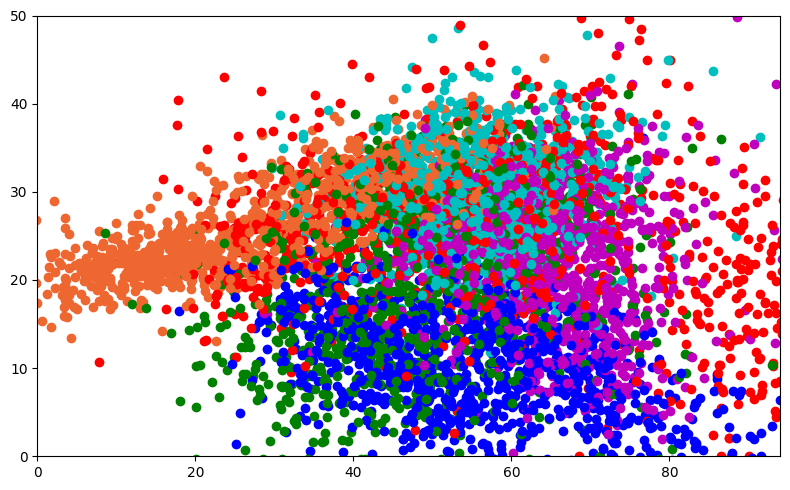

In [50]:
# import matplotlib.pyplot as plt
# from matplotlib.pyplot import scatter

plt.figure(figsize=(8,5))
plt.xlim(0, 94)
plt.ylim(0, 50)
for i in range(1025):
    plt.scatter(observations[0][i][0], observations[0][i][1], color='#ee6730')
    plt.scatter(observations[0][i][6], observations[0][i][7], color='b')
    plt.scatter(observations[0][i][12], observations[0][i][13], color='g')
    plt.scatter(observations[0][i][18], observations[0][i][19], color='r')
    plt.scatter(observations[0][i][24], observations[0][i][25], color='c')
    plt.scatter(observations[0][i][30], observations[0][i][31], color='m')

plt.tight_layout()
#     plt.show()
plt.savefig('LAL_k.png')
# print(counterfactual_KD_ending_positions)

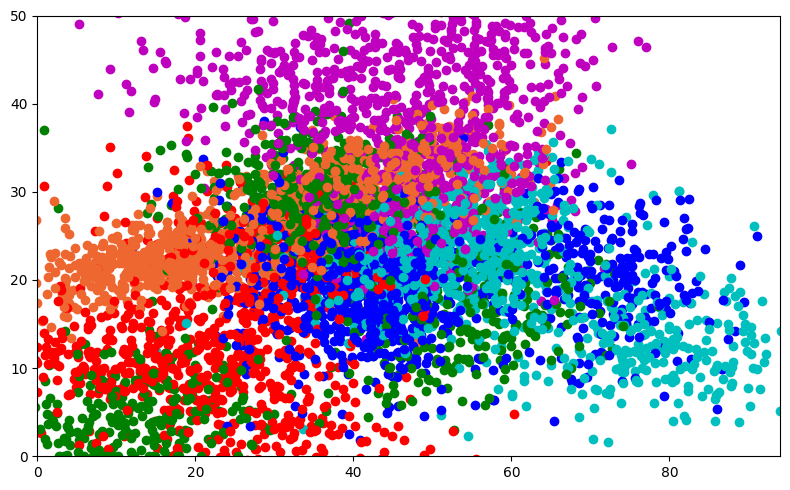

In [51]:
plt.figure(figsize=(8,5))
plt.xlim(0, 94)
plt.ylim(0, 50)
for i in range(1025):
    plt.scatter(observations[0][i][0], observations[0][i][1], color='#ee6730')
    plt.scatter(observations[0][i][36], observations[0][i][37], color='b')
    plt.scatter(observations[0][i][42], observations[0][i][43], color='g')
    plt.scatter(observations[0][i][48], observations[0][i][49], color='r')
    plt.scatter(observations[0][i][54], observations[0][i][55], color='c')
    plt.scatter(observations[0][i][60], observations[0][i][61], color='m')

plt.tight_layout()
#     plt.show()
plt.savefig('OKC_k.png')
# print(counterfactual_KD_ending_positions)

In [ ]:
import diffuser.utils as utils


#-----------------------------------------------------------------------------#
#----------------------------------- setup -----------------------------------#
#-----------------------------------------------------------------------------#

class Parser(utils.Parser):
#     dataset: str = 'hopper-medium-expert-v2'
    dataset: str = 'halfcheetah-medium-expert-v2'
    config: str = 'config.locomotion'

args = Parser().parse_args('diffusion')


#-----------------------------------------------------------------------------#
#---------------------------------- dataset ----------------------------------#
#-----------------------------------------------------------------------------#

dataset_config = utils.Config(
    args.loader,
    savepath=(args.savepath, 'dataset_config.pkl'),
    env=args.dataset,
    horizon=args.horizon,
    normalizer=args.normalizer,
    preprocess_fns=args.preprocess_fns,
    use_padding=args.use_padding,
    max_path_length=args.max_path_length,
)

render_config = utils.Config(
    args.renderer,
    savepath=(args.savepath, 'render_config.pkl'),
    env=args.dataset,
)

dataset = dataset_config()
renderer = render_config()

observation_dim = dataset.observation_dim
action_dim = dataset.action_dim


#-----------------------------------------------------------------------------#
#------------------------------ model & trainer ------------------------------#
#-----------------------------------------------------------------------------#

model_config = utils.Config(
    args.model,
    savepath=(args.savepath, 'model_config.pkl'),
    horizon=args.horizon,
    transition_dim=observation_dim + action_dim,
    cond_dim=observation_dim,
    dim_mults=args.dim_mults,
    attention=args.attention,
    device=args.device,
)

diffusion_config = utils.Config(
    args.diffusion,
    savepath=(args.savepath, 'diffusion_config.pkl'),
    horizon=args.horizon,
    observation_dim=observation_dim,
    action_dim=action_dim,
    n_timesteps=args.n_diffusion_steps,
    loss_type=args.loss_type,
    clip_denoised=args.clip_denoised,
    predict_epsilon=args.predict_epsilon,
    ## loss weighting
    action_weight=args.action_weight,
    loss_weights=args.loss_weights,
    loss_discount=args.loss_discount,
    device=args.device,
)

trainer_config = utils.Config(
    utils.Trainer,
    savepath=(args.savepath, 'trainer_config.pkl'),
    train_batch_size=args.batch_size,
    train_lr=args.learning_rate,
    gradient_accumulate_every=args.gradient_accumulate_every,
    ema_decay=args.ema_decay,
    sample_freq=args.sample_freq,
    save_freq=args.save_freq,
    label_freq=int(args.n_train_steps // args.n_saves),
    save_parallel=args.save_parallel,
    results_folder=args.savepath,
    bucket=args.bucket,
    n_reference=args.n_reference,
)

#-----------------------------------------------------------------------------#
#-------------------------------- instantiate --------------------------------#
#-----------------------------------------------------------------------------#

model = model_config()

diffusion = diffusion_config(model)

trainer = trainer_config(diffusion, dataset, renderer)


#-----------------------------------------------------------------------------#
#------------------------ test forward & backward pass -----------------------#
#-----------------------------------------------------------------------------#

utils.report_parameters(model)

print('Testing forward...', end=' ', flush=True)
batch = utils.batchify(dataset[0])
loss, _ = diffusion.loss(*batch)
loss.backward()
print('✓')


#-----------------------------------------------------------------------------#
#--------------------------------- main loop ---------------------------------#
#-----------------------------------------------------------------------------#

n_epochs = int(args.n_train_steps // args.n_steps_per_epoch)

# for i in range(n_epochs):
#     print(f'Epoch {i} / {n_epochs} | {args.savepath}')
#     trainer.train(n_train_steps=args.n_steps_per_epoch)



In [ ]:
batch = next(trainer.dataloader)

In [ ]:
type(batch)

In [ ]:
batch.trajectories.shape

In [ ]:
batch.conditions.keys()

In [ ]:
trainer.dataset[0].trajectories.shape

In [ ]:
print(trainer.dataset[0])

In [ ]:
print(trainer.dataset.fields["actions"].shape)

In [ ]:
print(trainer.dataset.fields["path_lengths"])

In [ ]:
import numpy as np

test_x = np.random.rand(4, 5, 6) #4 * 5 *6
test_x_min = test_x.min(axis=0) #5 * 6

#test_x_min[i, j] = min(test_x[:, i, j])

In [ ]:
def p_losses(x_start, cond):
    print(cond[0].shape)
    
def loss(x, *args):
    print(x.shape)
    batch_size = len(x)
#     t = torch.randint(0, self.n_timesteps, (batch_size,), device=x.device).long()
#     print(x.shape, *args.shape)
    p_losses(x, *args)

In [ ]:
loss(*batch)

In [ ]:
batch.trajectories[:, 0, :].shape

In [ ]:
trainer_ckpt = trainer_config(diffusion, dataset, renderer)

In [ ]:
trainer_ckpt.load(400000)